# Example regression problem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

math_df = pd.read_csv("student-mat.csv", sep=";")
port_df = pd.read_csv("student-por.csv", sep=";")

merged_df = math_df.copy().append(port_df, ignore_index=True)

merged_df.drop_duplicates(subset=["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"], inplace=True)

## Introduction

Dataset link: https://archive.ics.uci.edu/ml/datasets/student+performance

This dataset approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por)

It may seem like a mistake to combine two data sets from a language course and a science subject. 

However, for the sake of simplicity, the dataset has been concatenated by me.

Could it be that students with difficult family circumstances are better in humanities subjects and those with better circumstances are better in sciences - such a relationship could affect the validity of the regression, but this is a problem for a separate analysis.


## Getting to know the data

### Is the dataset complete?

<AxesSubplot:>

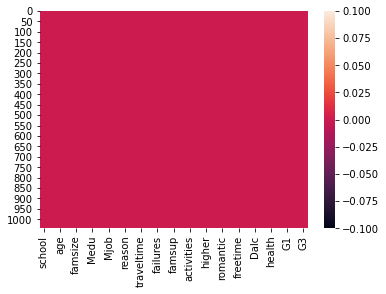

In [ ]:
sns.heatmap(merged_df.isnull())

### What are the columns?

In [3]:
merged_df.columns


Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

### What is the correlation?

In [ ]:
sns.heatmap(merged_df.corr())


## Plotting the data and looking further into it

### Distribution of the graes

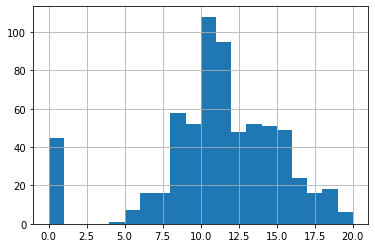

In [ ]:
scores = merged_df.G1.value_counts()

fig = merged_df.G3.hist(bins=20) ## who would except normal distribution 

### Gender breakdown of students

<AxesSubplot:ylabel='Students by gender'>

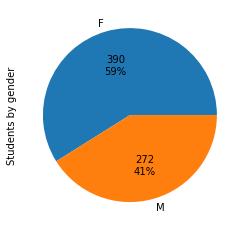

In [7]:
def label_function(val):
    return f'{val / 100 * len(merged_df):.0f}\n{val:.0f}%'

merged_df.groupby('sex').size().plot(kind='pie', ylabel='Students by gender', autopct=label_function)

### Is there significant diffrence between boys' and girls' grades?

In [ ]:
merged_df.groupby('sex')["G1", "G2", "G3"].describe() # not much

<ipython-input-8-0eebd6cb0e26>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merged_df.groupby('sex')["G1", "G2", "G3"].describe()


G1                                                       G2  \
     count       mean       std  min   25%   50%   75%   max  count   
sex                                                                   
F    390.0  10.653846  3.019333  4.0  8.00  10.0  13.0  19.0  390.0   
M    272.0  10.834559  3.172504  3.0  8.75  10.0  13.0  19.0  272.0   

                ...                 G3                                       \
          mean  ...   75%   max  count       mean       std  min  25%   50%   
sex             ...                                                           
F    10.635897  ...  13.0  18.0  390.0  10.628205  4.188087  0.0  9.0  11.0   
M    10.812500  ...  13.0  19.0  272.0  10.863971  3.990749  0.0  9.0  11.0   

                  
       75%   max  
sex               
F    13.75  19.0  
M    13.00  20.0  

[2 rows x 24 columns]

## Preprocessing

Data is well-prepared. No missing columns. However, the preparation is needed before using linear regression. 

In [ ]:
cat_cols = ["school", "sex", "famsize", "Mjob", "Fjob", "reason", "guardian", "address", "Pstatus", "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"]

X = merged_df[merged_df.columns[:-1]]
y = merged_df[merged_df.columns[-1:]]

numeric_cols = X.select_dtypes(np.number).dtypes.index.values.tolist()


We use OneHotEncoder to encode categorical variables.

OneHotEncoding produces extra features that are either 1 or 0. 

For example, if we have a nominal feature ``health` `where values might be ${0, 1, 2, 3}$ then the result of OneHotEncoding will be new columns: health_0, health_1, health_2, health_3 and value of 1 appears in a column respective to its value.

Other features that are not specified in ``cat_cols`` list are left as they are.

In [10]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder


ct = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop="first", handle_unknown='error'), cat_cols),
], remainder='passthrough').fit(X)

X_transformed = ct.transform(X)


## Introduction to our regression problem
At first, I will only try to predict ``G3`` at the same time including the ``G1`` and ``G2`` in our features set. To remind, ``G1 G2 G3`` are final grades for each period.

``G1`` is a numeric value. It is the student's final grade from the first period.

## Regression

### Given a student's 1st and 2nd period scores (G1 and G2), we predict the final semester score (G3)

#### Linear Regression

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)

metrics = []

model = LinearRegression().fit(X_train, y_train)
y_new = model.predict(X_test)

mae = mean_absolute_error(y_new, y_test)
mse = mean_squared_error(y_new, y_test)
rmse = mean_squared_error(y_new, y_test, squared=True)
score = model.score(X_test, y_test)

print(mae)
print(mse)
print(rmse)
print(score)

metrics.append((2, (mae, mse, rmse, score)))

1.0800744321665736
2.825507468276292
2.825507468276292
0.8332251420415347


#### Polymonial Regression

In [12]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

errors = []
for order in range(1,4):
    poly = PolynomialFeatures(order, include_bias = False)
    X_poly_train = poly.fit_transform(pd.DataFrame(X_train))
    
    model = LinearRegression()
    model.fit(X_poly_train, y_train)
    
    X_poly_test = poly.fit_transform(pd.DataFrame(X_test))
    y_new = model.predict(X_poly_test)
    
    print(mean_squared_error(y_new, y_test))

2.825507468276292
17.570133844435727
26.484572051842747


I omitted modeling the higher order polymonials because they may be too complex due to amount of features created by one hot encoding. There is no MSE error decrease on 2rd and 3rd polymonials. Because of that, we abandon higher polymonials for further regression in this notebook.


### Predict the first period score without past grades

In [13]:
X = merged_df[merged_df.columns[:-3]]
y = merged_df[merged_df.columns[-3:]]

ct = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop="first", handle_unknown='error'), cat_cols),
], remainder='passthrough').fit(X)

X_transformed = ct.transform(X)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y.G1, test_size=0.3, random_state=42)

model = LinearRegression().fit(X_train, y_train)
y_new = model.predict(X_test)

mae = mean_absolute_error(y_new, y_test)
mse = mean_squared_error(y_new, y_test)
rmse = mean_squared_error(y_new, y_test, squared=True)
score = model.score(X_test, y_test)

print(mae)
print(mse)
print(score)

metrics.append((0, (mae, mse, rmse, score)))

2.2151140378973517
7.360120296313553
0.2204983904023552


### Predict the second period score with only one past grade

In [15]:
# first try, predict only last score
X = merged_df[merged_df.columns[:-2]]
y = merged_df[merged_df.columns[-2:]]

ct = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop="first", handle_unknown='error'), cat_cols),
], remainder='passthrough').fit(X)

X_transformed = ct.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_transformed, y.G2, test_size=0.3, random_state=42)

model = LinearRegression().fit(X_train, y_train)
y_new = model.predict(X_test)

pmae = mean_absolute_error(y_new, y_test)
mse = mean_squared_error(y_new, y_test)
rmse = mean_squared_error(y_new, y_test, squared=True)
score = model.score(X_test, y_test)

print(mae)
print(mse)
print(score)

metrics.append((1, (mae, mse, rmse, score)))

2.2151140378973517
4.484767612683949
0.63774505629618


## Conclusion

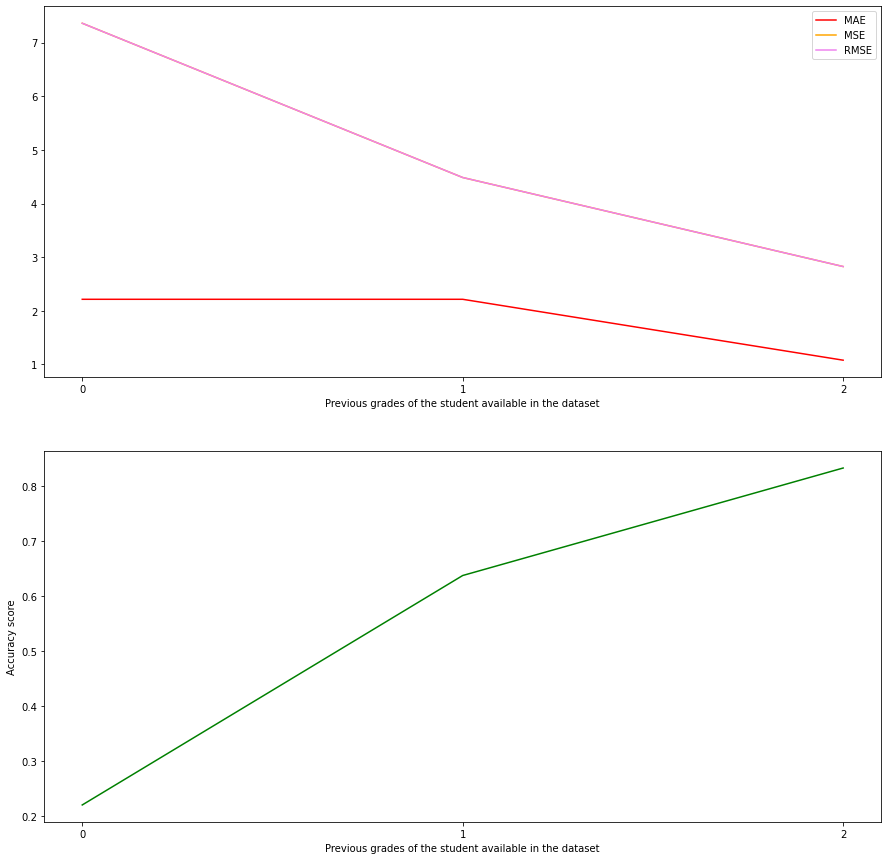

In [16]:
from matplotlib.ticker import MaxNLocator

metrics = sorted(metrics, key=lambda x: x[0])

fig, ax = plt.subplots(2)
fig.set_figheight(15)
fig.set_figwidth(15)

x, y = zip(*metrics)

current_y = list(zip(*y))[0]
ax[0].plot(x, current_y, color='red', label='MAE')

current_y = list(zip(*y))[1]
ax[0].plot(x, current_y, color='orange', label='MSE')

current_y = list(zip(*y))[2]
ax[0].plot(x, current_y, color='violet', label='RMSE')

ax[0].legend(loc="upper right")
ax[0].set_xlabel("Previous grades of the student available in the dataset")

ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

current_y = list(zip(*y))[3]
ax[1].plot(x, current_y, color='green')
ax[1].set_xlabel("Previous grades of the student available in the dataset")
ax[1].set_ylabel("Accuracy score")
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))


It is possible to accurately (accuracy of 83%) predict grades when we know student's previous grades. The accuracy quickly decreases as we have less previous grades to feed the linear regression and also error increases. However, due to the problem idea of regression the more proper metrics are MSE/RMSE.

The model still may be handy to roughly estimate general student's perfomance during course. We do not want to ideally predict grades, and the error metrics/cost functions are not that big (MAE: 2.12, MSE: 7.32) when predicting first grade). Focusing on MAE and RMSE, errors still are not that big.

Due to that we might consider:
* to do a binary classification problem rather than regression (will the student fail or pass?)
* to do a 5-level classification (score scale of fail/sufficient/satisfactory/good/very good/excellent)

The model shows that a student achievements are highly affected by previous performances.
